In [7]:
import swaxs_data_processing_tools as spt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from matplotlib import colors as mcolors
from matplotlib.ticker import FuncFormatter

In [2]:
# Define the scan numbers for each dataset
scan_numbers = {
    "MD_50": 42,
    "MD_80": 137,
    "CD_50": 103,
    "CD_80": 150
}

# Define azimuthal slices
slices = {
    'east':  (340, 20),   # Wraparound slice from 340° to 20°
    'north': (70, 110),   # From 70° to 110°
    'west':  (160, 200),  # From 160° to 200°
    'south': (250, 290),  # From 250° to 290°
    'full':  (0, 360)     # Entire range
}

samples = ["MD_50", "MD_80", "CD_50", "CD_80"]
directions = ['east', 'north', 'west', 'south', 'full']

# Dictionary to store all results
data = {}

for sample_name, scan_num in scan_numbers.items():
    print(f"\nProcessing {sample_name} (scan: {scan_num})...")

    # 1. Load data
    saxs_data = spt.load_transformed_data(scan_num, 'SAXS')
    waxs_data = spt.load_transformed_data(scan_num, 'WAXS')
    
    # 2. Reshape data
    saxs_data = spt.reshape_I(saxs_data)
    waxs_data = spt.reshape_I(waxs_data)

    # 3. Perform azimuthal integration on background-subtracted data
    I_saxs_azi = {}
    I_waxs_azi = {}
    
    for direction, (azi_min, azi_max) in slices.items():
        I_saxs_azi[direction] = spt.azimuthal_integration(saxs_data, azi_min=azi_min, azi_max=azi_max)
        I_waxs_azi[direction] = spt.azimuthal_integration(waxs_data, azi_min=azi_min, azi_max=azi_max)

    print(f"Azimuthal integration done for {sample_name}.")
    
    # 4. Using the full integration, get the background noise vectors
    saxs_background, saxs_background_pixels = spt.get_background_noise(
        I_saxs_azi['full'], 'SAXS', 'reshaped'
    )
    waxs_background, waxs_background_pixels = spt.get_background_noise(
        I_waxs_azi['full'], 'WAXS', 'reshaped'
    )

    # 5. Subtract background noise from each azimuthal slice
    for direction in slices.keys():
        I_saxs_azi[direction] = I_saxs_azi[direction] - saxs_background
        I_waxs_azi[direction] = I_waxs_azi[direction] - waxs_background

    print(f"Background noise removed for {sample_name}.")

    # 6. Extract q data
    q_saxs = saxs_data["q"]
    q_waxs = waxs_data["q"]

    # 7. Store all results in a dictionary
    data[sample_name] = {
        "I_saxs_azi": I_saxs_azi,
        "I_waxs_azi": I_waxs_azi,
        "q_saxs": q_saxs,
        "q_waxs": q_waxs,
        "waxs_background_pixels": waxs_background_pixels,
        "saxs_background_pixels": saxs_background_pixels
    }

print("\nAll datasets processed successfully!")
def print_all_keys(d, indent=0):
    """
    Recursively prints all dictionary keys at all levels.
    
    :param d:      The dictionary to print keys from.
    :param indent: Used to control indentation for nested levels.
    """
    for key, value in d.items():
        print("  " * indent + str(key))  # Print the current key with indentation
        if isinstance(value, dict):
            # Recursively print keys for nested dictionaries
            print_all_keys(value, indent + 1)

print("Dictionary: data, with keys:")
print_all_keys(data)


Processing MD_50 (scan: 42)...
Azimuthal integration done for MD_50.
Background noise removed for MD_50.

Processing MD_80 (scan: 137)...
Azimuthal integration done for MD_80.
Background noise removed for MD_80.

Processing CD_50 (scan: 103)...
Azimuthal integration done for CD_50.
Background noise removed for CD_50.

Processing CD_80 (scan: 150)...
Azimuthal integration done for CD_80.
Background noise removed for CD_80.

All datasets processed successfully!
Dictionary: data, with keys:
MD_50
  I_saxs_azi
    east
    north
    west
    south
    full
  I_waxs_azi
    east
    north
    west
    south
    full
  q_saxs
  q_waxs
  waxs_background_pixels
  saxs_background_pixels
MD_80
  I_saxs_azi
    east
    north
    west
    south
    full
  I_waxs_azi
    east
    north
    west
    south
    full
  q_saxs
  q_waxs
  waxs_background_pixels
  saxs_background_pixels
CD_50
  I_saxs_azi
    east
    north
    west
    south
    full
  I_waxs_azi
    east
    north
    west
    south
 

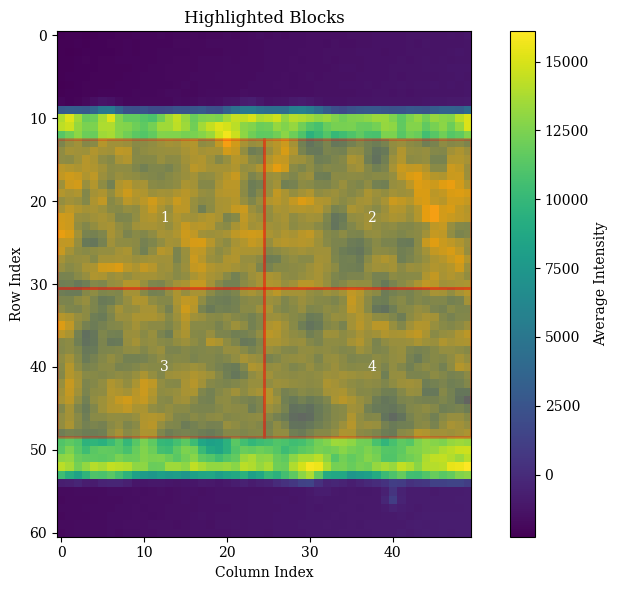

In [3]:
pixel_range_1 = ((13, 30), (0, 24))
pixel_range_2 = ((13, 30), (25, 49))
pixel_range_3 = ((31, 48), (0, 24))
pixel_range_4 = ((31, 48), (25, 49))

spt.plot_highlighted_blocks(data["MD_50"]["I_waxs_azi"]["west"], [pixel_range_1, pixel_range_2, pixel_range_3, pixel_range_4])

In [4]:
pixel_ranges = [pixel_range_1, pixel_range_2, pixel_range_3, pixel_range_4]

# Dictionary to store the results
average_intensity = {}

for sample_name in samples:
    average_intensity[sample_name] = {}
    for method in ["waxs", "saxs"]:
        intensity_method_key = f"I_{method}_azi"
        intensity_method_variable = f"I_{method}_data"
        average_intensity[sample_name][method] = {}
        # Loop over each pixel range first
        for i, pr in enumerate(pixel_ranges, start=1):
            pixel_range_key = f"pixel_range_{i}"
            
            # Create a nested dictionary for this sample and pixel_range
            average_intensity[sample_name][method][pixel_range_key] = {}
            
            (row_start, row_end), (col_start, col_end) = pr
            
            # Now compute average intensity for each direction within this pixel range
            for direction in directions:
                # For WAXS data, for example:
                intensity_method_variable = data[sample_name][intensity_method_key][direction]
                
                # Compute the mean intensity over the sub-block (rows × cols × q)
                avg_val = np.nanmean(intensity_method_variable[row_start:row_end+1, col_start:col_end+1, :], axis=(0,1))
                
                # Store it under [sample][pixel_range][direction]
                average_intensity[sample_name][method][pixel_range_key][direction] = avg_val


/tmp/ipykernel_1836560/507038910.py:27: RuntimeWarning: Mean of empty slice
  avg_val = np.nanmean(intensity_method_variable[row_start:row_end+1, col_start:col_end+1, :], axis=(0,1))


In [5]:
peak_range_saxs = (0.04, 0.35)

# Dictionary to store the Gaussian fit results
gauss_intensities = {}

for sample_name in samples:
    gauss_intensities[sample_name] = {}
        
    for i, pr in enumerate(pixel_ranges, start=1):
        # Retrieve the q-values (SAXS) and the intensity at this pixel range/direction
        q_saxs = data[sample_name]["q_saxs"]
        mask = (q_saxs >= peak_range_saxs[0]) & (q_saxs <= peak_range_saxs[1])
        intensity_saxs = average_intensity[sample_name]["saxs"][f"pixel_range_{i}"]['full']
        
        # Perform the Gaussian fit with method='SAXS'
        if sample_name == 'CD_80' and 'pr == pixel_range_4':
            print(f"Sample: {sample_name}")
            fitted_params, q_scaled, intensity_scaled, multi_gaussian = spt.gaussian_fit(
                q_saxs,
                intensity_saxs*q_saxs*q_saxs,
                method="SAXS"   # Key parameter: we want SAXS
            )
        elif sample_name == 'MD_80' and 'pr == pixel_range_2':
            print(f"Sample: {sample_name}")
            fitted_params, q_scaled, intensity_scaled, multi_gaussian = spt.gaussian_fit(
                q_saxs,
                intensity_saxs*q_saxs*q_saxs,
                method="SAXS"   # Key parameter: we want SAXS
            )
        else:
            print(f"Sample: {sample_name}")
            fitted_params, q_scaled, intensity_scaled, multi_gaussian = spt.gaussian_fit(
                q_saxs[mask],
                intensity_saxs[mask]*q_saxs[mask]*q_saxs[mask],
                method="SAXS"   # Key parameter: we want SAXS
            )
        
        # Store results in gauss_intensities dictionary
        gauss_intensities[sample_name][f"pixel_range_{i}"] = {
            "fitted_params": fitted_params,
            "q_scaled": q_scaled,
            "intensity_scaled": intensity_scaled,
            "multi_gaussian": multi_gaussian
        }

Sample: MD_50
Performing Gaussian Fit...
peak_indices: [ 476  688  953 1210 1345]
peak_count: 5
properties['widths']: [  4.19929641 408.44684028   4.15905631   4.12849906   9.27788802]
Fitted Parameters:
  Peak 1: A=0.6118, mu=0.1910, sigma=0.0784
  Peak 2: A=0.2637, mu=0.3616, sigma=0.0461
  Peak 3: A=0.0097, mu=0.2912, sigma=0.0229
  Peak 4: A=0.1648, mu=0.0000, sigma=0.0413
  Peak 5: A=0.2005, mu=0.0000, sigma=0.0188
Sample: MD_50
Performing Gaussian Fit...
peak_indices: [ 551  689  866  953 1065]
peak_count: 5
properties['widths']: [  5.26736071 402.85301914   4.32159459   4.30786717   5.67700746]
Fitted Parameters:
  Peak 1: A=0.5471, mu=0.1881, sigma=0.0750
  Peak 2: A=0.0000, mu=0.2320, sigma=0.1985
  Peak 3: A=0.3104, mu=0.3627, sigma=0.0565
  Peak 4: A=0.1826, mu=0.0000, sigma=0.0210
  Peak 5: A=0.1487, mu=0.0000, sigma=0.0459
Sample: MD_50
Performing Gaussian Fit...
peak_indices: [ 133  511  561  708  842  935  992 1065 1143 1206 1350]
peak_count: 11
properties['widths']: [  

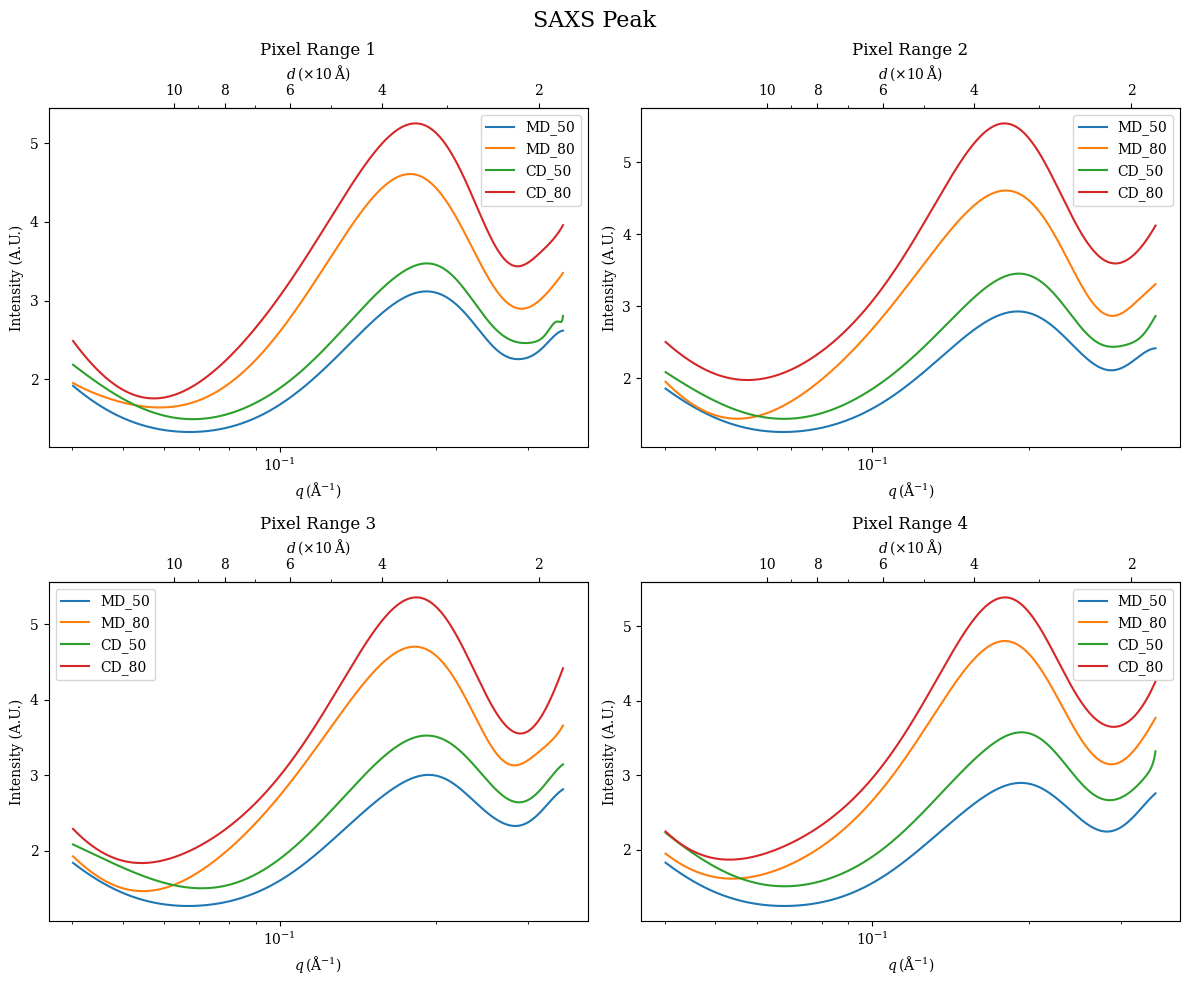

In [8]:
peak_range_saxs = (0.04, 0.35)
# Create 4 subplots for the 4 pixel ranges
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()  # Flatten the 2x2 array of axes into a list

for i, pr in enumerate(pixel_ranges, start=1):
    ax = axs[i-1]
    
    # Loop over the 4 samples
    for sample_name in samples:
        # Retrieve data from gauss_intensities
        data_dict = gauss_intensities[sample_name][f"pixel_range_{i}"]
        q_vals = data_dict["q_scaled"]           # q-values used in the fitting (unscaled for SAXS)
        I_vals = data_dict["intensity_scaled"]   # intensity values (unscaled for SAXS)
        popt = data_dict["fitted_params"]        # fitted Gaussian parameters
        multi_gauss = data_dict["multi_gaussian"]
        
        # Mask the data to the specified peak range
        mask = (q_vals >= peak_range_saxs[0]) & (q_vals <= peak_range_saxs[1])
    
        # Evaluate the multi-Gaussian fit on q_fine
        fit_curve = multi_gauss(q_vals[mask], *popt)
        
        # Plot the fitted curve
        ax.plot(q_vals[mask], fit_curve, label=f"{sample_name}")
    
    ax.set_title(f"Pixel Range {i}")
    ax.set_xscale("log")
    ax.set_yticks([2, 3, 4, 5])
    ax.set_ylabel("Intensity (A.U.)")
    ax.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$")

     # Add secondary x-axis for d
    secax = ax.secondary_xaxis('top', functions = (spt.q_to_d, spt.d_to_q))
    secax.set_xticks([20, 40, 60, 80, 100])
    secax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x / 10)}"))
    secax.xaxis.offsetText.set_visible(False)                                      # Hide the default offset
    secax.set_xlabel(r"$d \, (\times 10 \, \mathrm{\AA})$")
    
    ax.legend()

fig.suptitle(f"SAXS Peak", fontsize=16)
plt.tight_layout()
plt.show()

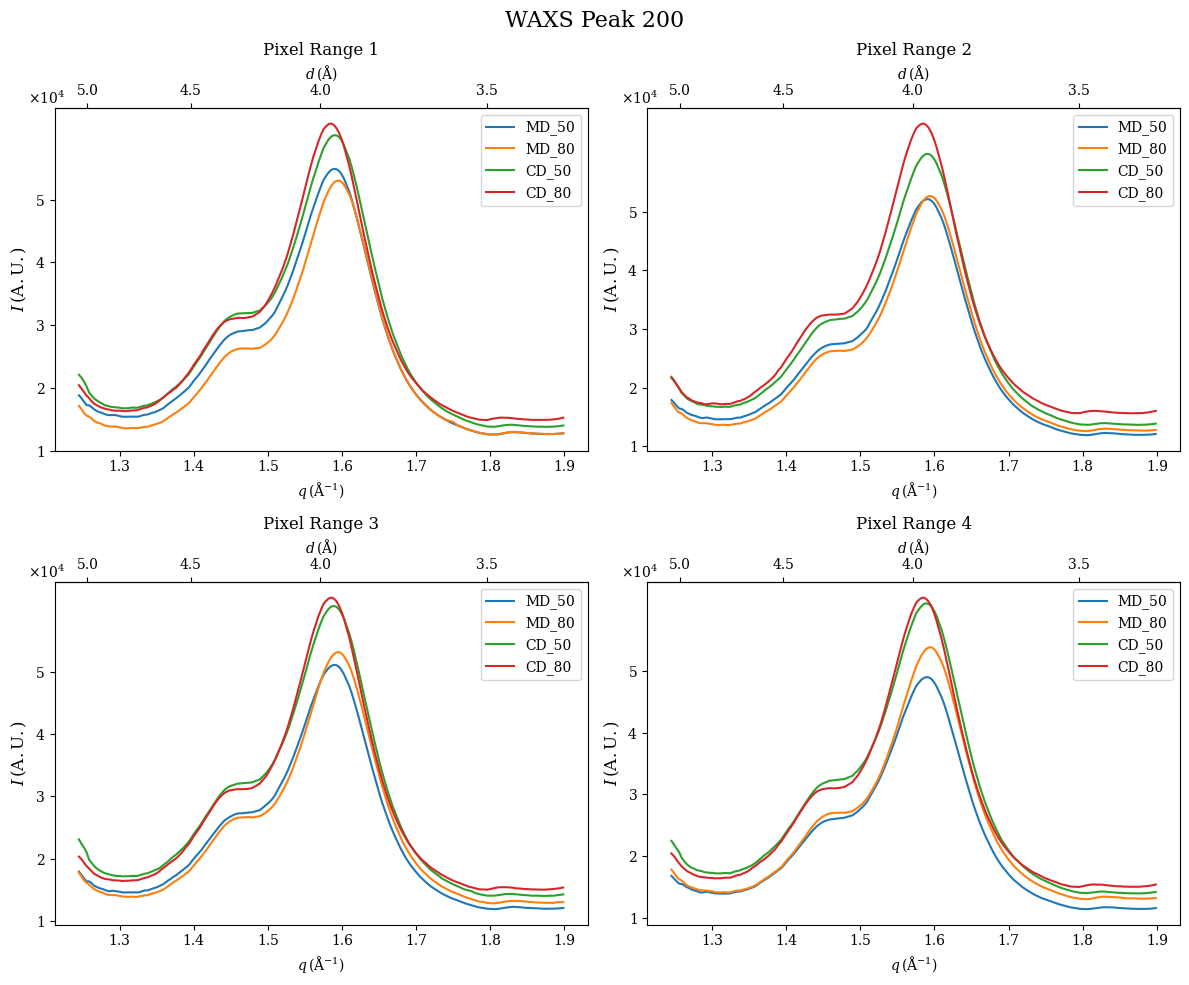

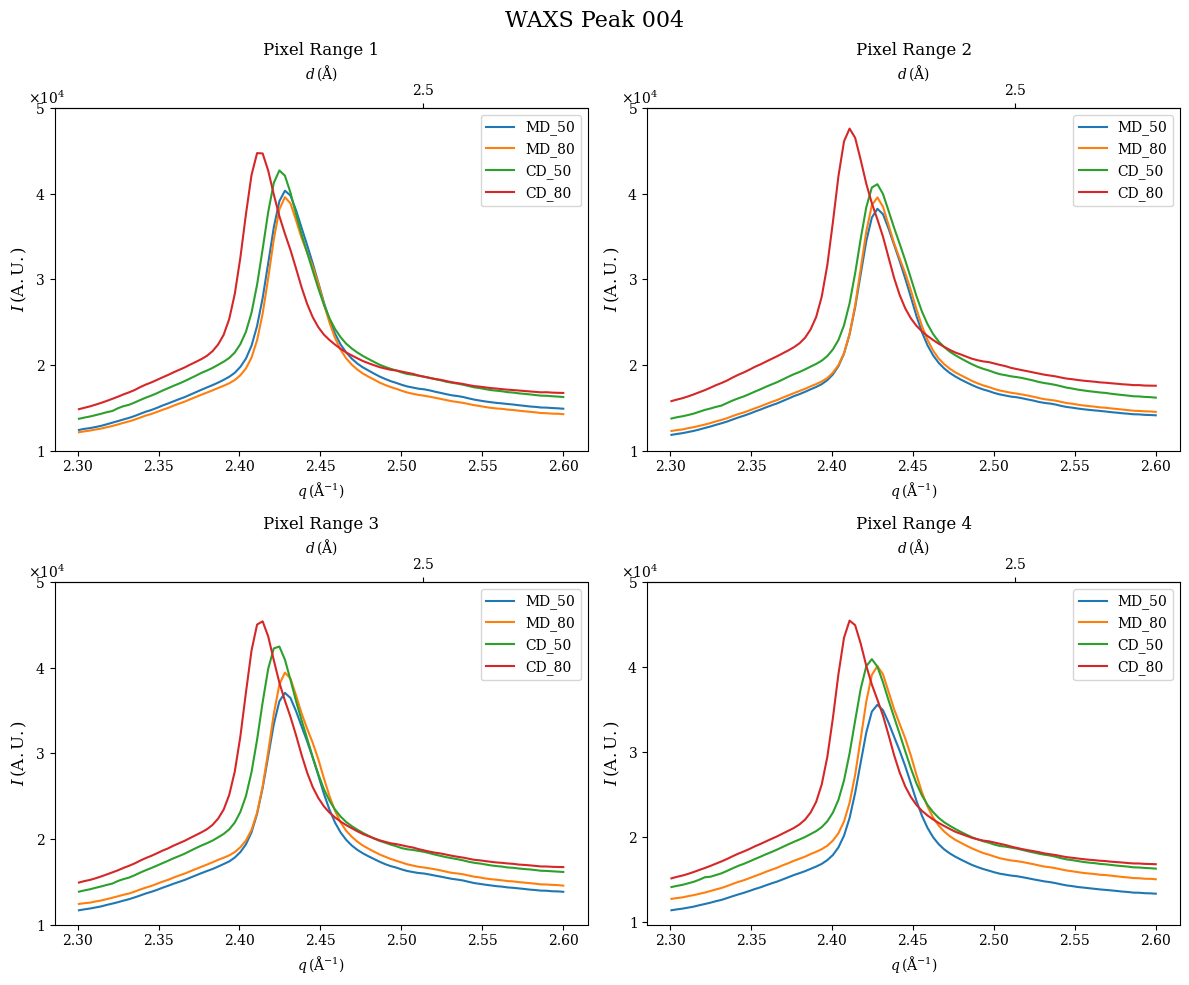

In [9]:
peak_ranges_waxs = {
    "200": (1.2, 1.9),
    "004": (2.3, 2.6)
}

for peak_label, (qmin, qmax) in peak_ranges_waxs.items():
    
    # Create a figure with 2×2 subplots for the 4 pixel ranges
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()  # Flatten 2×2 grid for easier indexing
    
    for i, pr in enumerate(pixel_ranges, start=1):
        ax = axs[i-1]
        
        # Loop over the 4 samples
        for sample_name in samples:
            # Retrieve the q-array and WAXS intensity
            q_vals = data[sample_name]["q_waxs"]
            I_vals = average_intensity[sample_name]["waxs"][f"pixel_range_{i}"]["full"]
            
            # Apply mask to restrict q-range
            mask = (q_vals >= qmin) & (q_vals <= qmax)
            
            # Plot the data in the selected q-range
            ax.plot(q_vals[mask], I_vals[mask], label=f"{sample_name}")
        
        # Configure each subplot
        ax.set_title(f"Pixel Range {i}")
        ax.set_ylabel("Intensity (A.U.)")
        ax.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$")

        # Set y-axis to scientific notation
        if pr == "200":
            ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000])
        else:
            ax.set_yticks([10000, 20000, 30000, 40000, 50000])
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.yaxis.get_offset_text().set_fontsize(10)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

        # Adjust the position of the scientific notation offset label
        ax.yaxis.offsetText.set_x(-0.05)  # Adjust X-position

        secax = ax.secondary_xaxis('top', functions = (spt.q_to_d, spt.d_to_q))
        secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
        secax.set_xticks([1, 2, 2.3, 2.4, 2.5, 3, 3.5, 4, 4.5, 5])
        ax.legend()
    
    fig.suptitle(f"WAXS Peak {peak_label}", fontsize=16)
    plt.tight_layout()
    plt.show()